# Volatility Prediction

In [1]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import pandas as pd
import datetime
import time
from arch import arch_model
import matplotlib.pyplot as plt
#from numba import jit
from sklearn.metrics import mean_squared_error as mse
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [2]:
stocks = '^GSPC'
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2021, 8, 1)
s_p500 = yf.download(stocks, start=start, end = end, interval='1d')

[*********************100%***********************]  1 of 1 completed


In [3]:
ret = 100*(s_p500.pct_change()[1:]['Adj Close'])

realized_vol = ret.rolling(5).std()

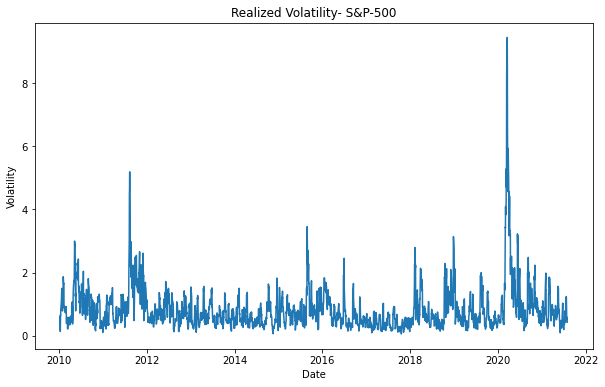

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol.index,realized_vol)
plt.title('Realized Volatility- S&P-500') 
plt.ylabel('Volatility')
plt.xlabel('Date') 
plt.show()

In [5]:
retv = ret.values

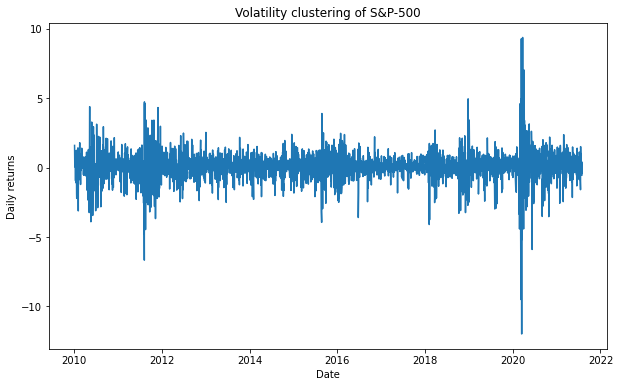

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(s_p500.index[1:], ret)
plt.title('Volatility clustering of S&P-500') 
plt.ylabel('Daily returns')
plt.xlabel('Date') 
plt.show()

## ARCH

In [7]:
n = 252
split_date = ret.iloc[-n:].index

In [8]:
split_date

DatetimeIndex(['2020-07-31', '2020-08-03', '2020-08-04', '2020-08-05',
               '2020-08-06', '2020-08-07', '2020-08-10', '2020-08-11',
               '2020-08-12', '2020-08-13',
               ...
               '2021-07-19', '2021-07-20', '2021-07-21', '2021-07-22',
               '2021-07-23', '2021-07-26', '2021-07-27', '2021-07-28',
               '2021-07-29', '2021-07-30'],
              dtype='datetime64[ns]', name='Date', length=252, freq=None)

In [9]:
arch = arch_model(ret, mean='zero', vol='ARCH', p=1).fit(last_obs=split_date[0], disp='off')
print(arch.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3723.13
Distribution:                  Normal   AIC:                           7450.25
Method:            Maximum Likelihood   BIC:                           7462.03
                                        No. Observations:                 2662
Date:                Wed, Jul 27 2022   Df Residuals:                     2662
Time:                        14:12:28   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.7067  5.298e-02     13.339  1.381e-40 [  0.603,  0.81

In [10]:
bic_arch = []

for p in range(1, 5):
        arch = arch_model(ret, mean='zero', vol='ARCH', p=p).fit(last_obs=split_date[0], disp='off')
        bic_arch.append(arch.bic)
        if arch.bic == np.min(bic_arch):
            best_param = p
arch = arch_model(ret, mean='zero', vol='ARCH', p=best_param).fit(last_obs=split_date[0], disp='off')
print(arch.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3373.06
Distribution:                  Normal   AIC:                           6756.12
Method:            Maximum Likelihood   BIC:                           6785.56
                                        No. Observations:                 2662
Date:                Wed, Jul 27 2022   Df Residuals:                     2662
Time:                        14:12:29   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.2619  2.507e-02     10.450  1.469e-25   [  0.21

In [11]:
forecast_arch = arch.forecast(start=split_date[0])

rmse_arch = np.sqrt(mse(realized_vol[-len(split_date):], 
                        np.sqrt(forecast_arch.variance.iloc[-len(split_date):])))

print('The RMSE value of ARCH model is {:.4f}'.format(rmse_arch))

The RMSE value of ARCH model is 0.2217


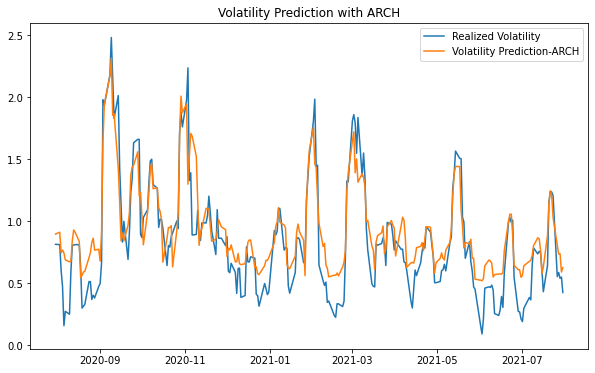

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol[-len(split_date):], label='Realized Volatility')
plt.plot(np.sqrt(forecast_arch.variance.iloc[-len(split_date):]), 
         label='Volatility Prediction-ARCH')
plt.title('Volatility Prediction with ARCH', fontsize=12)
plt.legend()
plt.show()

## GARCH

In [13]:
garch = arch_model(ret, mean='zero', vol='GARCH', p=1, o=0, q=1).fit(last_obs=split_date[0], disp='off')
print(garch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3321.81
Distribution:                  Normal   AIC:                           6649.61
Method:            Maximum Likelihood   BIC:                           6667.27
                                        No. Observations:                 2662
Date:                Wed, Jul 27 2022   Df Residuals:                     2662
Time:                        14:12:29   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0363  8.025e-03      4.518  6.243e-06 [2.

In [14]:
bic_garch = []

for p in range(1, 5):
    for q in range(1, 5):
        garch = arch_model(ret, mean='zero',vol='GARCH', p=p, o=0, q=q).fit(last_obs=split_date[0], disp='off')
        bic_garch.append(garch.bic)
        if garch.bic == np.min(bic_garch):
            best_param = p, q
garch = arch_model(ret, mean='zero', vol='GARCH',
                   p=best_param[0], o=0, q=best_param[1]).fit(last_obs=split_date[0], disp='off')
print(garch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3321.81
Distribution:                  Normal   AIC:                           6649.61
Method:            Maximum Likelihood   BIC:                           6667.27
                                        No. Observations:                 2662
Date:                Wed, Jul 27 2022   Df Residuals:                     2662
Time:                        14:12:30   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0363  8.025e-03      4.518  6.243e-06 [2.

In [15]:
forecast_garch = garch.forecast(start=split_date[0])

rmse_garch = np.sqrt(mse(realized_vol[-len(split_date):],
                         np.sqrt(forecast_garch.variance.iloc[-len(split_date):])))
print('The RMSE value of GARCH model is {:.4f}'.format(rmse_garch))

The RMSE value of GARCH model is 0.2560


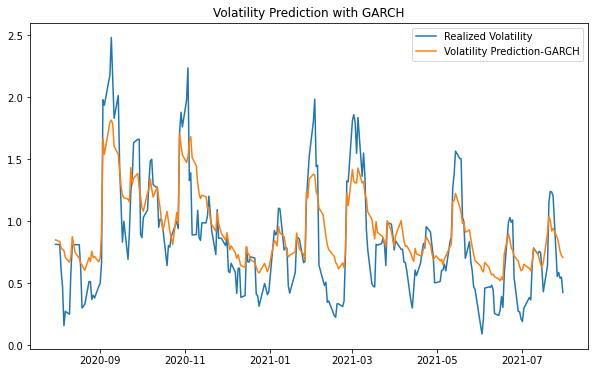

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol[-len(split_date):], label='Realized Volatility')
plt.plot(np.sqrt(forecast_garch.variance.iloc[-len(split_date):]), 
         label='Volatility Prediction-GARCH')
plt.title('Volatility Prediction with GARCH', fontsize=12)
plt.legend()
plt.show()

## GJR-GARCH

In [17]:
bic_gjr_garch = []

for p in range(1, 5):
    for q in range(1, 5):
        gjrgarch = arch_model(ret, mean='zero', p=p, o=1, q=q).fit(last_obs=split_date[0], disp='off')
        bic_gjr_garch.append(gjrgarch.bic)
        if gjrgarch.bic == np.min(bic_gjr_garch):
            best_param = p, q
gjrgarch = arch_model(ret,mean='zero', p=best_param[0], o=1, q=best_param[1]).fit(last_obs=split_date[0], disp='off')

print(gjrgarch.summary())

                     Zero Mean - GJR-GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -3253.22
Distribution:                  Normal   AIC:                           6514.44
Method:            Maximum Likelihood   BIC:                           6537.98
                                        No. Observations:                 2662
Date:                Wed, Jul 27 2022   Df Residuals:                     2662
Time:                        14:12:30   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0373  6.825e-03      5.469  4.528e-08 

In [18]:
forecast_gjrgarch = gjrgarch.forecast(start=split_date[0])

rmse_gjr_garch = np.sqrt(mse(realized_vol[-len(split_date):],
                             np.sqrt(forecast_gjrgarch.variance.iloc[-len(split_date):])))
print('The RMSE value of GJR-GARCH models is {:.4f}'
      .format(rmse_gjr_garch))

The RMSE value of GJR-GARCH models is 0.2431


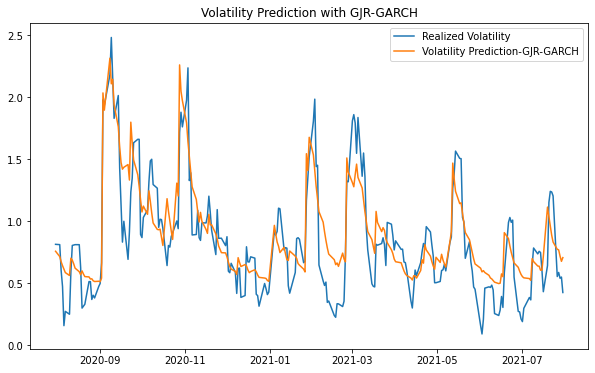

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol[-len(split_date):], label='Realized Volatility')
plt.plot(np.sqrt(forecast_gjrgarch.variance.iloc[-len(split_date):]),
         label='Volatility Prediction-GJR-GARCH')
plt.title('Volatility Prediction with GJR-GARCH', fontsize=12)
plt.legend()
plt.show()

## EGARCH

In [20]:
bic_egarch = []

for p in range(1, 5):
    for q in range(1, 5):
        egarch = arch_model(ret, mean='zero', vol='EGARCH', p=p, q=q).fit(last_obs=split_date[0], disp='off')
        bic_egarch.append(egarch.bic)
        if egarch.bic == np.min(bic_egarch):
            best_param = p, q
egarch = arch_model(ret, mean='zero', vol='EGARCH',
                    p=best_param[0], q=best_param[1]).fit(last_obs=split_date[0], disp='off')

print(egarch.summary())

                       Zero Mean - EGARCH Model Results                       
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -3340.04
Distribution:                  Normal   AIC:                           6686.08
Method:            Maximum Likelihood   BIC:                           6703.74
                                        No. Observations:                 2662
Date:                Wed, Jul 27 2022   Df Residuals:                     2662
Time:                        14:12:31   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      3.3499e-03  6.797e-03      0.493      0.622 

In [21]:
forecast_egarch = egarch.forecast(start=split_date[0])

rmse_egarch = np.sqrt(mse(realized_vol[-len(split_date):],
                          np.sqrt(forecast_egarch.variance.iloc[-len(split_date):])))
print('The RMSE value of EGARCH models is {:.4f}'.format(rmse_egarch))

The RMSE value of EGARCH models is 0.2799


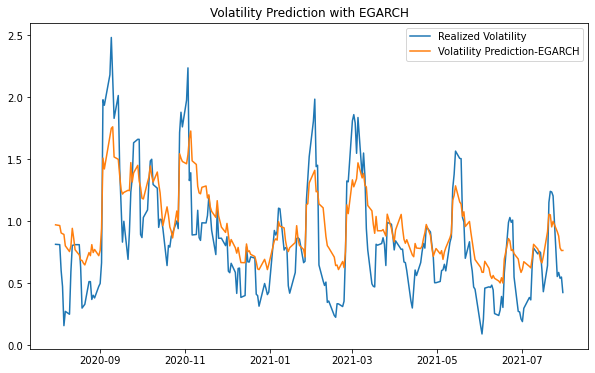

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol[-len(split_date):], label='Realized Volatility')
plt.plot(np.sqrt(forecast_egarch.variance.iloc[-len(split_date):]),
         label='Volatility Prediction-EGARCH')
plt.title('Volatility Prediction with EGARCH', fontsize=12)
plt.legend()
plt.show()

In [23]:
classical_model_results = pd.DataFrame([['ARCH', rmse_arch], ['GARCH', rmse_garch], ['GJR-GARCH', rmse_gjr_garch], ['EGARCH', rmse_egarch]], 
                             columns = ['Model', 'RMSE'])

classical_model_results

,Model,RMSE
0,ARCH,0.221671
1,GARCH,0.256039
2,GJR-GARCH,0.243114
3,EGARCH,0.279861


## SVM Regression: SVR-GARCH

In [24]:
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV

In [25]:
realized_vol = ret.rolling(5).std()
realized_vol = pd.DataFrame(realized_vol)
realized_vol.reset_index(drop=True, inplace=True)

In [26]:
returns_svm = ret**2
returns_svm = returns_svm.reset_index()
del returns_svm['Date']

In [27]:
X = pd.concat([realized_vol, returns_svm], axis=1, ignore_index=True)
X = X[4:].copy()
X = X.reset_index()
X.drop('index', axis=1, inplace=True)

In [28]:
realized_vol = realized_vol.dropna().reset_index()
realized_vol.drop('index', axis=1, inplace=True)

In [29]:
svr_poly = SVR(kernel='poly', degree=2)
svr_lin = SVR(kernel='linear')
svr_rbf = SVR(kernel='rbf')

### SVR-GARCH-Linear

In [30]:
para_grid = {'gamma': sp_rand(),
             'C': sp_rand(),
             'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_lin, para_grid, random_state=1)
clf.fit(X.iloc[:-n].values, 
        realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_lin = clf.predict(X.iloc[-n:])

In [31]:
predict_svr_lin = pd.DataFrame(predict_svr_lin)
predict_svr_lin.index = ret.iloc[-n:].index

In [32]:
rmse_svr = np.sqrt(mse(realized_vol.iloc[-n:],
                       predict_svr_lin))
print('The RMSE value of SVR with Linear Kernel is {:.6f}'
      .format(rmse_svr))

The RMSE value of SVR with Linear Kernel is 0.057352


In [33]:
realized_vol.index = ret.iloc[4:].index

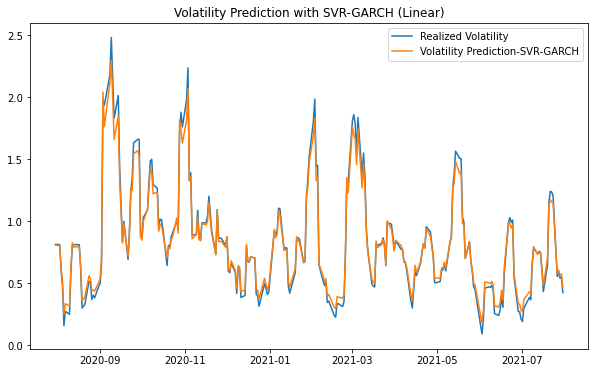

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol.iloc[-n:], label='Realized Volatility')
plt.plot(predict_svr_lin, label='Volatility Prediction-SVR-GARCH')
plt.title('Volatility Prediction with SVR-GARCH (Linear)', fontsize=12)
plt.legend()
plt.show()

### SVR-GARCH RBF

In [35]:
para_grid ={'gamma': sp_rand(),
            'C': sp_rand(),
            'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_rbf, para_grid, random_state=1)
clf.fit(X.iloc[:-n].values, 
        realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_rbf = clf.predict(X.iloc[-n:])

In [36]:
predict_svr_rbf = pd.DataFrame(predict_svr_rbf)
predict_svr_rbf.index = ret.iloc[-n:].index

In [37]:
rmse_svr_rbf = np.sqrt(mse(realized_vol.iloc[-n:],
                           predict_svr_rbf))
print('The RMSE value of SVR with RBF Kernel is  {:.6f}'
      .format(rmse_svr_rbf))

The RMSE value of SVR with RBF Kernel is  0.076688


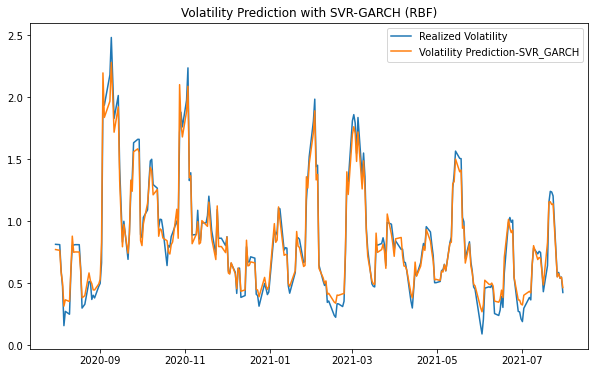

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol.iloc[-n:], label='Realized Volatility')
plt.plot(predict_svr_rbf, label='Volatility Prediction-SVR_GARCH')
plt.title('Volatility Prediction with SVR-GARCH (RBF)', fontsize=12)
plt.legend()
plt.show()

## MLP Neural Network: MLP-NN-GARCH

In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout, RepeatVector, TimeDistributed, Activation, Flatten, MaxPooling2D


In [40]:
model = Sequential([
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(1, activation="linear"),])

model.compile(loss='mse', optimizer='adam')

In [41]:
epochs_trial = np.arange(50, 105, 5)
batch_trial = np.arange(50, 105, 5)
MLP_pred = []
MLP_RMSE = []
for i, j, k in zip(range(10), epochs_trial, batch_trial):
    np.random.seed(1)
    tf.random.set_seed(2)
    model.fit(X.iloc[:-n].values,
              realized_vol.iloc[1:-(n-1)].values.reshape(-1,),
              batch_size=k, epochs=j, verbose=False)
    MLP_predict = model.predict(np.asarray(X.iloc[-n:]))
    MLP_RMSE.append(np.sqrt(mse(realized_vol.iloc[-n:],
                            MLP_predict.flatten())))
    MLP_pred.append(MLP_predict)
    print('MLP_RMSE_{}:{:.6f}'.format(i+1, MLP_RMSE[i]))

MLP_RMSE_1:0.092229
MLP_RMSE_2:0.054011
MLP_RMSE_3:0.053808
MLP_RMSE_4:0.061163
MLP_RMSE_5:0.092255
MLP_RMSE_6:0.059845
MLP_RMSE_7:0.066493
MLP_RMSE_8:0.084824
MLP_RMSE_9:0.065713
MLP_RMSE_10:0.062481


In [42]:
rmse_mlp = MLP_RMSE[MLP_RMSE.index(min(MLP_RMSE))]

print('The RMSE value of MLP-NN-GARCH model {:.4f}'
      .format(rmse_mlp))

The RMSE value of MLP-NN-GARCH model 0.0538


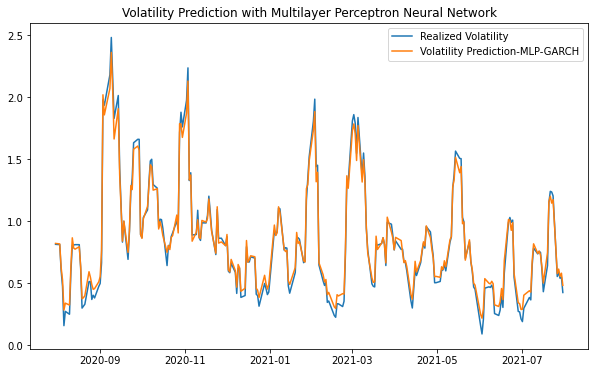

In [43]:
MLP_predict = pd.DataFrame(MLP_pred[MLP_RMSE.index(min(MLP_RMSE))])
MLP_predict.index = ret.iloc[-n:].index

plt.figure(figsize=(10, 6))
plt.plot(realized_vol[-len(split_date):],label='Realized Volatility')
plt.plot(MLP_predict,label='Volatility Prediction-MLP-GARCH')
plt.title('Volatility Prediction with Multilayer Perceptron Neural Network',  fontsize=12)
plt.legend()
plt.show()

# Recurrent Neural Network: RNN-GARCH

In [44]:
n_steps = 20
n_features = 2

In [45]:
model = Sequential()
model.add(SimpleRNN(128, activation='relu', 
                    input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mse'])

In [46]:
# split a multivariate sequence into samples
def split_sequences(X, n_steps):
    X_seq = list()
    for i in range(len(X)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(X):
            break
        # gather input and output parts of the pattern
        seq_x = X.iloc[i:end_ix, :]
        X_seq.append(seq_x)
    return np.array(X_seq)


In [47]:
X_train = split_sequences(X.iloc[:-n], n_steps)
X_train.shape

(2639, 20, 2)

In [48]:
y_train = realized_vol.iloc[n_steps:-n+1].values
y_train.shape

(2639, 1)

In [49]:
for i in range(len(X_train)):
    print(X_train[i], y_train[i])

[[0.61304722 0.08304352]
 [0.13376285 0.03051155]
 [0.53772788 0.88006278]
 [0.65806155 0.69321038]
 [0.64686003 0.0588754 ]
 [0.82391166 1.17140146]
 [1.04251858 1.56240665]
 [1.07265192 1.12313994]
 [1.24604867 3.58909364]
 [1.35525185 4.90223383]
 [1.49965969 0.21142505]
 [1.08874636 0.17666887]
 [1.27991675 0.23815886]
 [1.14886572 1.39659001]
 [0.7830858  0.96612658]
 [1.08660937 2.03521863]
 [1.23488158 1.6829739 ]
 [1.26298874 0.29968086]
 [1.86706628 9.69741819]
 [1.85170695 0.08393298]] [1.64288562]
[[0.13376285 0.03051155]
 [0.53772788 0.88006278]
 [0.65806155 0.69321038]
 [0.64686003 0.0588754 ]
 [0.82391166 1.17140146]
 [1.04251858 1.56240665]
 [1.07265192 1.12313994]
 [1.24604867 3.58909364]
 [1.35525185 4.90223383]
 [1.49965969 0.21142505]
 [1.08874636 0.17666887]
 [1.27991675 0.23815886]
 [1.14886572 1.39659001]
 [0.7830858  0.96612658]
 [1.08660937 2.03521863]
 [1.23488158 1.6829739 ]
 [1.26298874 0.29968086]
 [1.86706628 9.69741819]
 [1.85170695 0.08393298]
 [1.6428856

 [4.64340496e-01 2.57383279e-01]] [0.46478756]
[[1.00881836e+00 2.60789773e-01]
 [9.66884980e-01 3.85425469e-03]
 [7.79782695e-01 1.71135726e-03]
 [1.87933073e-01 4.78927759e-02]
 [2.39650735e-01 1.56725560e-02]
 [1.25002549e-01 1.64215000e-04]
 [1.29685447e-01 1.29878053e-02]
 [3.22930902e-01 5.04172467e-01]
 [3.22312718e-01 3.50488571e-02]
 [2.97429210e-01 4.48373403e-06]
 [3.83272348e-01 1.22327590e-01]
 [3.86501467e-01 5.12584311e-04]
 [3.96639821e-01 6.51611013e-01]
 [5.34527485e-01 4.16635511e-01]
 [5.32831965e-01 2.39135488e-03]
 [5.15564757e-01 6.53158610e-03]
 [5.18586045e-01 7.12925616e-03]
 [5.08794003e-01 6.09305911e-01]
 [4.64340496e-01 2.57383279e-01]
 [4.64787557e-01 1.35946054e-02]] [0.46498223]
[[9.66884980e-01 3.85425469e-03]
 [7.79782695e-01 1.71135726e-03]
 [1.87933073e-01 4.78927759e-02]
 [2.39650735e-01 1.56725560e-02]
 [1.25002549e-01 1.64215000e-04]
 [1.29685447e-01 1.29878053e-02]
 [3.22930902e-01 5.04172467e-01]
 [3.22312718e-01 3.50488571e-02]
 [2.97429210e-0

[[4.77811712e-01 2.55224416e-02]
 [4.10581525e-01 9.87902844e-04]
 [4.31658874e-01 1.12796578e-02]
 [3.00795987e-01 3.75344143e-01]
 [2.91969473e-01 9.20146674e-04]
 [3.00332612e-01 7.61081684e-02]
 [3.07521312e-01 5.86332704e-03]
 [3.16079802e-01 2.17865933e-02]
 [2.10375629e-01 8.73973659e-02]
 [3.67128731e-01 3.75146359e-01]
 [4.09294771e-01 2.05983649e-01]
 [4.41086385e-01 1.92589628e-01]
 [4.56561327e-01 1.43060733e-02]
 [7.58125480e-01 2.00900762e+00]
 [6.95038322e-01 1.55584585e-01]
 [9.22234759e-01 2.87686718e+00]
 [9.39990707e-01 3.67749495e-02]
 [1.23705585e+00 1.58796279e+00]
 [1.10508217e+00 3.69021133e-01]
 [1.29416356e+00 1.83160255e+00]] [0.9349039]
[[4.10581525e-01 9.87902844e-04]
 [4.31658874e-01 1.12796578e-02]
 [3.00795987e-01 3.75344143e-01]
 [2.91969473e-01 9.20146674e-04]
 [3.00332612e-01 7.61081684e-02]
 [3.07521312e-01 5.86332704e-03]
 [3.16079802e-01 2.17865933e-02]
 [2.10375629e-01 8.73973659e-02]
 [3.67128731e-01 3.75146359e-01]
 [4.09294771e-01 2.05983649e-0

[[1.63625501e-01 9.46122469e-03]
 [1.76742612e-01 1.79859099e-02]
 [1.72441072e-01 5.30196026e-03]
 [1.52755780e-01 5.99816413e-02]
 [1.54221991e-01 2.42702760e-03]
 [1.80237175e-01 4.76834560e-02]
 [1.89549180e-01 3.56871215e-02]
 [1.84409839e-01 2.71326715e-02]
 [2.06505027e-01 5.82948568e-02]
 [2.03750296e-01 1.32211266e-03]
 [6.78465956e-01 2.09509463e+00]
 [6.68474698e-01 1.62707876e-02]
 [8.81667128e-01 1.00877005e+00]
 [8.79156488e-01 2.48809302e-03]
 [8.84987368e-01 2.01669229e-02]
 [9.23344152e-01 2.38299492e+00]
 [9.17679467e-01 3.36857317e-02]
 [7.05599014e-01 1.35175751e-02]
 [9.21066535e-01 9.88191028e-01]
 [9.15488666e-01 1.19273026e-01]] [0.54076935]
[[1.76742612e-01 1.79859099e-02]
 [1.72441072e-01 5.30196026e-03]
 [1.52755780e-01 5.99816413e-02]
 [1.54221991e-01 2.42702760e-03]
 [1.80237175e-01 4.76834560e-02]
 [1.89549180e-01 3.56871215e-02]
 [1.84409839e-01 2.71326715e-02]
 [2.06505027e-01 5.82948568e-02]
 [2.03750296e-01 1.32211266e-03]
 [6.78465956e-01 2.09509463e+

[[ 1.28002862  1.26575908]
 [ 1.2798149   0.110601  ]
 [ 0.78505457  0.2916922 ]
 [ 0.78528342  0.53676105]
 [ 0.62680734  0.0285094 ]
 [ 0.50645247  0.41765799]
 [ 0.53817446  0.02658353]
 [ 0.37118324  0.03398615]
 [ 0.36493756  0.08526065]
 [ 0.40054212  0.22144421]
 [ 0.35575851  0.14558191]
 [ 0.58382704  1.10630491]
 [ 1.46175555 11.23163173]
 [ 1.66525694  9.16878131]
 [ 1.44723513  0.14277369]
 [ 1.67791321 19.50391996]
 [ 1.7276002   0.67870253]
 [ 3.44320297 21.19610607]
 [ 3.40940246  7.90053824]
 [ 4.09176842 17.81058668]] [3.82252903]
[[ 1.2798149   0.110601  ]
 [ 0.78505457  0.2916922 ]
 [ 0.78528342  0.53676105]
 [ 0.62680734  0.0285094 ]
 [ 0.50645247  0.41765799]
 [ 0.53817446  0.02658353]
 [ 0.37118324  0.03398615]
 [ 0.36493756  0.08526065]
 [ 0.40054212  0.22144421]
 [ 0.35575851  0.14558191]
 [ 0.58382704  1.10630491]
 [ 1.46175555 11.23163173]
 [ 1.66525694  9.16878131]
 [ 1.44723513  0.14277369]
 [ 1.67791321 19.50391996]
 [ 1.7276002   0.67870253]
 [ 3.44320297 

In [50]:
np.random.seed(1)
tf.random.set_seed(2)

model_rnn = model.fit(X_train,
                      y_train,
                      batch_size=60, epochs=60, shuffle=False, verbose=False)

In [51]:
X_test = split_sequences(X.iloc[-n-n_steps+1:], n_steps)
X_test.shape

(252, 20, 2)

In [52]:
RNN_pred = model.predict(X_test)
RNN_pred

array([[0.8132594 ],
       [0.82766503],
       [0.48361385],
       [0.514133  ],
       [0.38295984],
       [0.33979177],
       [0.35615855],
       [0.55592275],
       [0.81638485],
       [0.8847511 ],
       [0.8770028 ],
       [0.71555954],
       [0.34181237],
       [0.33033067],
       [0.36030096],
       [0.3603611 ],
       [0.5960144 ],
       [0.58443946],
       [0.5777258 ],
       [0.60372174],
       [0.44617248],
       [0.5621368 ],
       [0.46231246],
       [0.83816206],
       [1.943436  ],
       [1.9468454 ],
       [1.9582708 ],
       [2.259556  ],
       [1.8227186 ],
       [2.0616665 ],
       [1.3084524 ],
       [1.1714624 ],
       [0.9368337 ],
       [0.911107  ],
       [0.78869647],
       [0.8091851 ],
       [0.99185336],
       [1.4568298 ],
       [1.4361866 ],
       [1.4152501 ],
       [1.6112598 ],
       [1.162814  ],
       [1.0761602 ],
       [0.7788818 ],
       [0.69230574],
       [1.1717961 ],
       [1.3029907 ],
       [1.501

In [53]:
rmse_rnn = np.sqrt(mse(realized_vol.iloc[-n:], RNN_pred))

print('The RMSE value of RNN-GARCH model {:.4f}'
      .format(rmse_rnn))

The RMSE value of RNN-GARCH model 0.1615


In [54]:
RNN_pred = pd.DataFrame(RNN_pred)
RNN_pred.index = ret.iloc[-n:].index

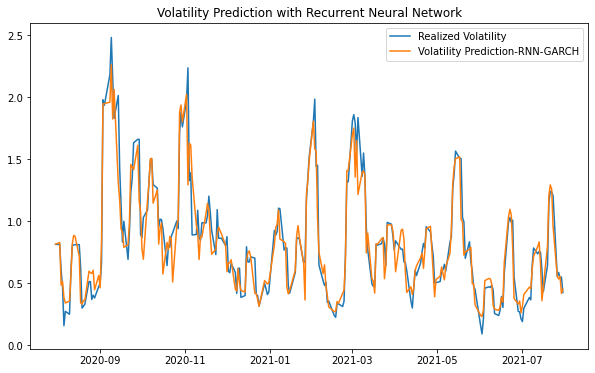

In [55]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol[-len(split_date):],label='Realized Volatility')
plt.plot(RNN_pred,label='Volatility Prediction-RNN-GARCH')
plt.title('Volatility Prediction with Recurrent Neural Network', fontsize=12)
plt.legend()
plt.show()

# Long Short-Term Memory Neural Network: LSTM-GARCH

In [56]:
n_steps = 20
n_features = 2

In [57]:
model = Sequential()
model.add(LSTM(128, activation='relu',
               input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['mse'])

In [58]:
np.random.seed(1)
tf.random.set_seed(2)

model_lstm = model.fit(X_train,
                       y_train,
                       batch_size=60, epochs=60, shuffle=False, verbose=False)

In [59]:
LSTM_pred = model.predict(X_test)
LSTM_pred

array([[0.7577062 ],
       [0.7163195 ],
       [0.6189169 ],
       [0.55601746],
       [0.48987216],
       [0.4286428 ],
       [0.37775385],
       [0.47477055],
       [0.7596096 ],
       [0.8329653 ],
       [0.77020836],
       [0.6368926 ],
       [0.49495262],
       [0.3955812 ],
       [0.3486926 ],
       [0.34567863],
       [0.5132666 ],
       [0.5770818 ],
       [0.6617402 ],
       [0.6179724 ],
       [0.5664638 ],
       [0.48876724],
       [0.49392575],
       [0.7633243 ],
       [1.7153966 ],
       [1.9765882 ],
       [2.33479   ],
       [2.3329847 ],
       [2.1755202 ],
       [1.7462728 ],
       [1.444309  ],
       [1.1196399 ],
       [0.9198967 ],
       [0.8220594 ],
       [0.9016416 ],
       [0.9660533 ],
       [1.0303631 ],
       [1.3897066 ],
       [1.3971162 ],
       [1.4681547 ],
       [1.4731716 ],
       [1.3227994 ],
       [1.0250163 ],
       [0.7949945 ],
       [0.77830476],
       [1.0728201 ],
       [1.325958  ],
       [1.557

In [60]:
rmse_lstm = np.sqrt(mse(realized_vol.iloc[-n:], LSTM_pred))
rmse_lstm

0.14829858430139084

In [61]:
LSTM_pred = pd.DataFrame(LSTM_pred)
LSTM_pred.index = ret.iloc[-n:].index

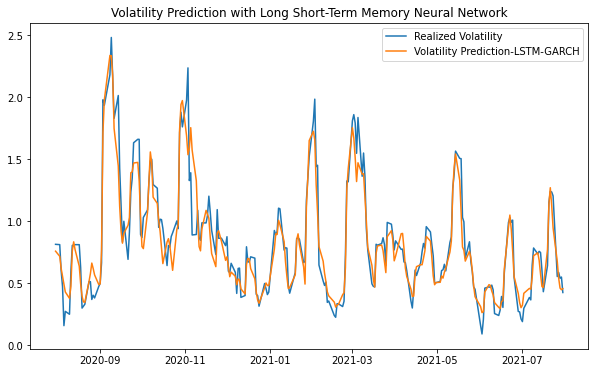

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol[-len(split_date):],label='Realized Volatility')
plt.plot(LSTM_pred,label='Volatility Prediction-LSTM-GARCH')
plt.title('Volatility Prediction with Long Short-Term Memory Neural Network', fontsize=12)
plt.legend()
plt.show()

In [63]:
ML_model_results = pd.DataFrame([['SVR-GARCH-Linear', rmse_svr], ['SVR-GARCH RBF', rmse_svr_rbf], 
                                 ['MLP-NN-GARCH', rmse_mlp], ['RNN-GARCH', rmse_rnn], ['LSTM-GARCH', rmse_lstm]], 
                             columns = ['Model', 'RMSE'])

ML_model_results

,Model,RMSE
0,SVR-GARCH-Linear,0.057352
1,SVR-GARCH RBF,0.076688
2,MLP-NN-GARCH,0.053808
3,RNN-GARCH,0.161463
4,LSTM-GARCH,0.148299


In [64]:
pd.concat([classical_model_results, ML_model_results], axis=0, ignore_index=True)

,Model,RMSE
0,ARCH,0.221671
1,GARCH,0.256039
2,GJR-GARCH,0.243114
3,EGARCH,0.279861
4,SVR-GARCH-Linear,0.057352
5,SVR-GARCH RBF,0.076688
6,MLP-NN-GARCH,0.053808
7,RNN-GARCH,0.161463
8,LSTM-GARCH,0.148299


# Conclusion: The ML-based volatility models significantly outperform the classical volatility models by a large margin, with the reduction in RMSE ranging between 30-80%.